In [1]:
from __future__ import annotations
from typing import Any

from pprint import pprint
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder
from sklearn.svm import LinearSVC
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import make_pipeline
from sklearn.metrics import ConfusionMatrixDisplay

# Render plots as SVG
%config InlineBackend.figure_format = 'svg'

In [2]:
df = (pd
    .read_csv(
        'data/crosswriters.csv', 
        encoding='utf-8', 
        usecols=['text', 'author', 'author_gender', 'reader_age_group']
    )
    .astype({
        'author': 'category', 
        'author_gender': 'category', 
        'reader_age_group': 'category'
    })
)
df.sample(10)

,text,author,author_gender,reader_age_group
6263,he couldve gone and mingled with the punters....,J.K. Rowling,F,adult
5167,"us!’ harry shouted, pounding on the door. ‘ope...",J.K. Rowling,F,child
212,what’s happening to your own body; being all a...,David Almond,M,child
4995,it. it has learned what to expect when the cla...,J.K. Rowling,F,child
3545,time. they loved to watch her lace her fingers...,Philip Pullman,M,child
2947,food in the bowl for him in the morning and ag...,Neil Gaiman,M,adult
4189,shy fire; and she had discovered already that ...,Philip Pullman,M,child
1038,harris saw my new name and address. harris pho...,Anne Fine,F,child
2892,“dogs!”) and ran along the top of the garden w...,Neil Gaiman,M,child
4172,him nickname the steam king —promoted new comp...,Philip Pullman,M,child


## SVM: Child vs Adult 

### All authors

In [3]:
print("Before:", df['reader_age_group'].value_counts(), sep="\n", end="\n\n")

enc = LabelEncoder()
enc.fit(df['reader_age_group'])
encoded_labels = dict(zip(enc.classes_, enc.transform(enc.classes_))) # will use that in the cm later
df['reader_age_group'] = enc.transform(df['reader_age_group'])

print("After:", df['reader_age_group'].value_counts(), sep="\n")
encoded_labels

Before:
child    4412
adult    2457
Name: reader_age_group, dtype: int64

After:
1    4412
0    2457
Name: reader_age_group, dtype: int64


{'adult': 0, 'child': 1}

In [4]:
X = df['text']
y = df['reader_age_group']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=97, stratify=y)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((5495,), (1374,), (5495,), (1374,))

In [5]:
vect = TfidfVectorizer(max_features=5000, stop_words='english')  # remove stopwords due to high frequency
svm  = LinearSVC()
pipe = make_pipeline(vect, svm)

pprint(pipe.get_params(), sort_dicts=False)

{'memory': None,
 'steps': [('tfidfvectorizer',
            TfidfVectorizer(max_features=5000, stop_words='english')),
           ('linearsvc', LinearSVC())],
 'verbose': False,
 'tfidfvectorizer': TfidfVectorizer(max_features=5000, stop_words='english'),
 'linearsvc': LinearSVC(),
 'tfidfvectorizer__analyzer': 'word',
 'tfidfvectorizer__binary': False,
 'tfidfvectorizer__decode_error': 'strict',
 'tfidfvectorizer__dtype': <class 'numpy.float64'>,
 'tfidfvectorizer__encoding': 'utf-8',
 'tfidfvectorizer__input': 'content',
 'tfidfvectorizer__lowercase': True,
 'tfidfvectorizer__max_df': 1.0,
 'tfidfvectorizer__max_features': 5000,
 'tfidfvectorizer__min_df': 1,
 'tfidfvectorizer__ngram_range': (1, 1),
 'tfidfvectorizer__norm': 'l2',
 'tfidfvectorizer__preprocessor': None,
 'tfidfvectorizer__smooth_idf': True,
 'tfidfvectorizer__stop_words': 'english',
 'tfidfvectorizer__strip_accents': None,
 'tfidfvectorizer__sublinear_tf': False,
 'tfidfvectorizer__token_pattern': '(?u)\\b\\w\\w+\\b'

In [6]:
param_grid = {
    'linearsvc__class_weight': ['balanced', None],
    'tfidfvectorizer__ngram_range': [(2, 3), (3, 3)],
    'tfidfvectorizer__lowercase': [False]  # already lowercased
}

In [7]:
gs = GridSearchCV(
    pipe, 
    param_grid, 
    cv=10, 
    scoring=('accuracy', 'f1_macro'),
    n_jobs=-1,  # for some weird reason, setting `n_jobs` != 1 causes `verbose` not to work...
    refit='f1_macro',
    verbose=5
)
gs.fit(X_train, y_train)

Fitting 10 folds for each of 4 candidates, totalling 40 fits


GridSearchCV(cv=10,
             estimator=Pipeline(steps=[('tfidfvectorizer',
                                        TfidfVectorizer(max_features=5000,
                                                        stop_words='english')),
                                       ('linearsvc', LinearSVC())]),
             n_jobs=-1,
             param_grid={'linearsvc__class_weight': ['balanced', None],
                         'tfidfvectorizer__lowercase': [False],
                         'tfidfvectorizer__ngram_range': [(2, 3), (3, 3)]},
             refit='f1_macro', scoring=('accuracy', 'f1_macro'), verbose=5)

In [8]:
# Problem: `GridSearchCV.best_estimator_.get_params()` doesn't return *just* the parameters that changed.
# As a result, it's hard to know which one(s) have overriden the defaults.
# So, I made a function that returns the parameters that changed - inspired by `set.difference()`.
# I also made another one that looks at the keys and returns the ones that their values are different.

def dict_difference_values(d1: dict, d2: dict) -> dict:
    return {k: v for k, v in d2.items() if v != d1[k]}

def dict_difference_keys(d1: dict, d2: dict) -> dict:
    return {k: v for k, v in d2.items() if k not in d1}

In [9]:
print(f"Best score: {gs.best_score_:.3f}", end="\n\n")

default_params = pipe.get_params()
best_est_params = gs.best_estimator_.get_params()
dict_difference_values(default_params, best_est_params)

Best score: 0.932



{'steps': [('tfidfvectorizer',
   TfidfVectorizer(lowercase=False, max_features=5000, ngram_range=(2, 3),
                   stop_words='english')),
  ('linearsvc', LinearSVC(class_weight='balanced'))],
 'tfidfvectorizer': TfidfVectorizer(lowercase=False, max_features=5000, ngram_range=(2, 3),
                 stop_words='english'),
 'linearsvc': LinearSVC(class_weight='balanced'),
 'tfidfvectorizer__lowercase': False,
 'tfidfvectorizer__ngram_range': (2, 3),
 'linearsvc__class_weight': 'balanced'}

In [10]:
y_pred = gs.predict(X_test)

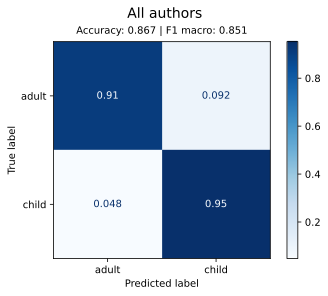

In [11]:
palette = sns.color_palette('gist_stern_r', as_cmap=True)
classes = [label for label in encoded_labels]
title = "All authors"

# Subtitle
scorers = []
for scoring, _ in gs.scorer_.items():
    score = gs.cv_results_[f'mean_test_{scoring}'].mean()
    scoring = scoring.replace('_', ' ').capitalize()
    scorers.append(f'{scoring}: {score:.3f}')

subtitle = " | ".join(scorers)

disp = ConfusionMatrixDisplay.from_estimator(
    gs,
    X_test,
    y_test,
    display_labels=classes,
    cmap=plt.cm.Blues,
    normalize='true',
)

plt.suptitle(title, y=1, fontsize=14)
disp.ax_.set_title(subtitle, fontsize=10, pad=8)
disp.ax_.tick_params(axis='x');

In [12]:
features_names = gs.best_estimator_.named_steps['tfidfvectorizer'].get_feature_names_out()
clf = gs.best_estimator_.named_steps['linearsvc']

In [13]:
def plot_coefficients(
    classifier: Any, 
    feature_names: Any,
    *, 
    who: str = 'all', 
    n_features: int = 20
) -> None:

    coef = classifier.coef_.ravel()
    top_pos_coefficients = np.argsort(coef)[-n_features:]
    top_neg_coefficients = np.argsort(coef)[:n_features]
    top_coefficients = np.hstack([top_neg_coefficients, top_pos_coefficients])

    feature_names = np.array(feature_names)

    # Plot
    plt.figure(figsize=(n_features * 0.75, n_features * 0.25))

    # Appearance
    colors = ['#a52040' if c < 0 else '#404080' for c in coef[top_coefficients]]
    plt.bar(np.arange(2 * n_features), coef[top_coefficients], color=colors, zorder=2)
    plt.suptitle(f"Coefficients ({classifier.__class__.__name__})", y=.975, fontsize=14)

    # - Subtitle (main title is already set as `suptitle`)
    if who == 'all':
        title = "All authors"
    else:
        title = who.title()
    plt.title(f"{title} (top {n_features * 2} features)", x=.485, pad=8)

    # - Axis labels
    _, _, ymin, ymax = plt.axis()
    range = int(abs(ymin - ymax))
    step = 0.5

    plt.yticks(np.arange((range * -1) / 2, (range / 2) + step, step))
    plt.xticks(np.arange(0, 2 * n_features), feature_names[top_coefficients], ha='right', rotation=60)
    plt.grid(axis='both', linestyle='--', alpha=.25, zorder=1)
    plt.show()

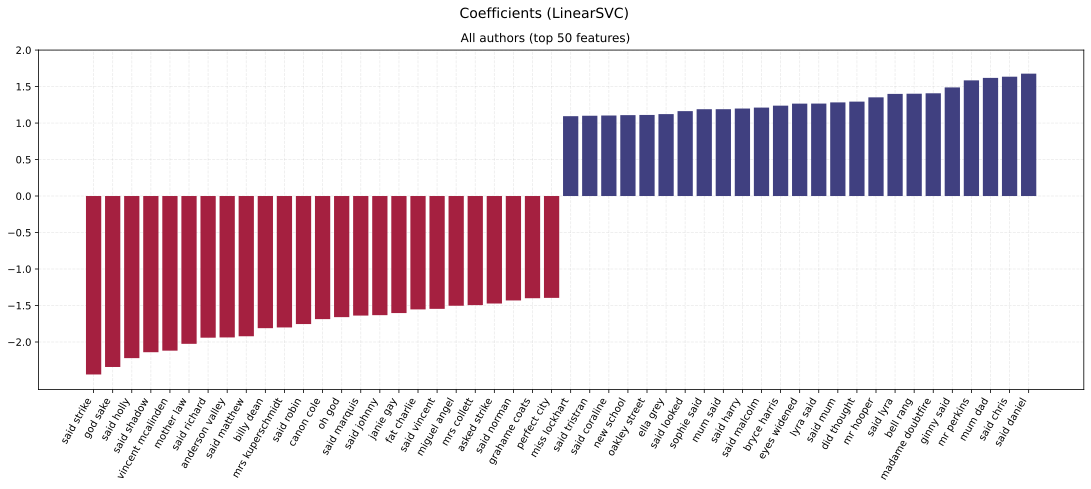

In [14]:
plot_coefficients(clf, features_names, n_features=25)

## Individual authors

=========================================== David Almond ===========================================

X_train: (620,)	 X_test: (155,)
y_train: (620,)	 y_test: (155,)

Fitting 10 folds for each of 4 candidates, totalling 40 fits
Best score: 0.930

Default params were overriden by:
{'steps': [('tfidfvectorizer', TfidfVectorizer(lowercase=False, max_df=0.5, max_features=5000,
                ngram_range=(2, 2), stop_words='english')), ('linearsvc', LinearSVC(class_weight='balanced'))], 'tfidfvectorizer': TfidfVectorizer(lowercase=False, max_df=0.5, max_features=5000,
                ngram_range=(2, 2), stop_words='english'), 'linearsvc': LinearSVC(class_weight='balanced'), 'tfidfvectorizer__lowercase': False, 'tfidfvectorizer__max_df': 0.5, 'tfidfvectorizer__ngram_range': (2, 2), 'linearsvc__class_weight': 'balanced'}



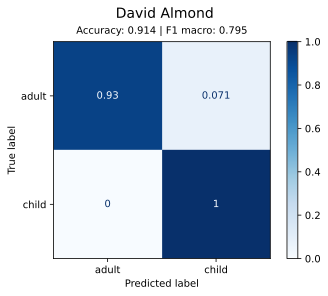

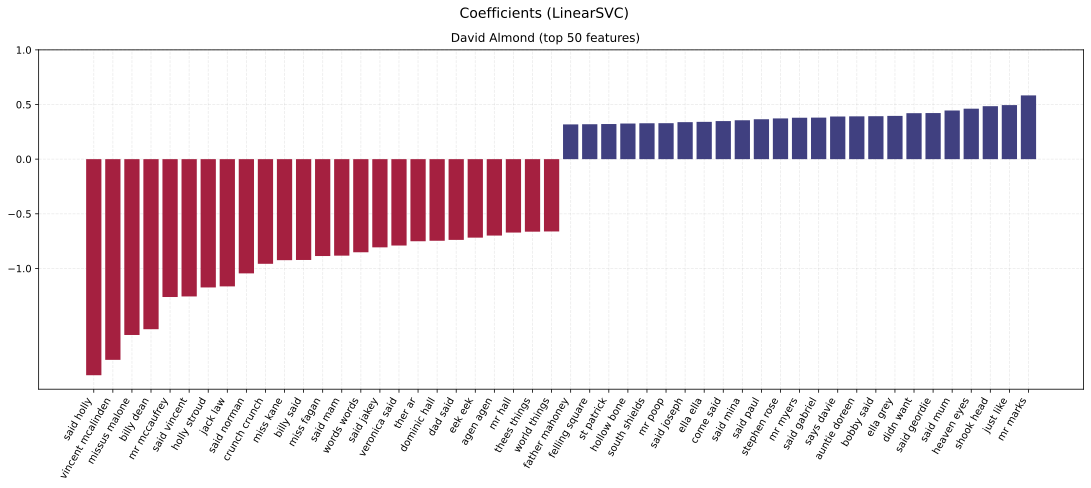

============================================ Anne Fine =============================================

X_train: (1237,)	 X_test: (310,)
y_train: (1237,)	 y_test: (310,)

Fitting 10 folds for each of 4 candidates, totalling 40 fits
Best score: 0.936

Default params were overriden by:
{'steps': [('tfidfvectorizer', TfidfVectorizer(lowercase=False, max_df=0.5, max_features=5000,
                ngram_range=(2, 2), stop_words='english')), ('linearsvc', LinearSVC(class_weight='balanced'))], 'tfidfvectorizer': TfidfVectorizer(lowercase=False, max_df=0.5, max_features=5000,
                ngram_range=(2, 2), stop_words='english'), 'linearsvc': LinearSVC(class_weight='balanced'), 'tfidfvectorizer__lowercase': False, 'tfidfvectorizer__max_df': 0.5, 'tfidfvectorizer__ngram_range': (2, 2), 'linearsvc__class_weight': 'balanced'}



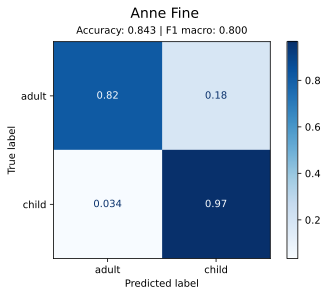

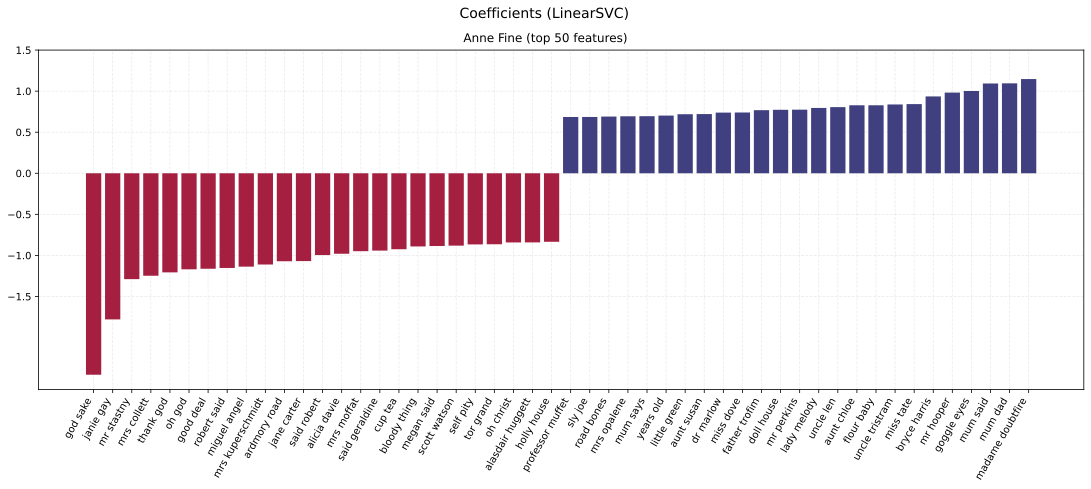

=========================================== Neil Gaiman ============================================

X_train: (553,)	 X_test: (139,)
y_train: (553,)	 y_test: (139,)

Fitting 10 folds for each of 4 candidates, totalling 40 fits
Best score: 0.980

Default params were overriden by:
{'steps': [('tfidfvectorizer', TfidfVectorizer(lowercase=False, max_df=0.5, max_features=5000,
                ngram_range=(2, 2), stop_words='english')), ('linearsvc', LinearSVC(class_weight='balanced'))], 'tfidfvectorizer': TfidfVectorizer(lowercase=False, max_df=0.5, max_features=5000,
                ngram_range=(2, 2), stop_words='english'), 'linearsvc': LinearSVC(class_weight='balanced'), 'tfidfvectorizer__lowercase': False, 'tfidfvectorizer__max_df': 0.5, 'tfidfvectorizer__ngram_range': (2, 2), 'linearsvc__class_weight': 'balanced'}



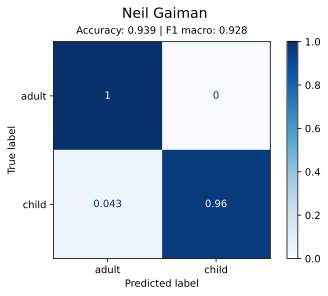

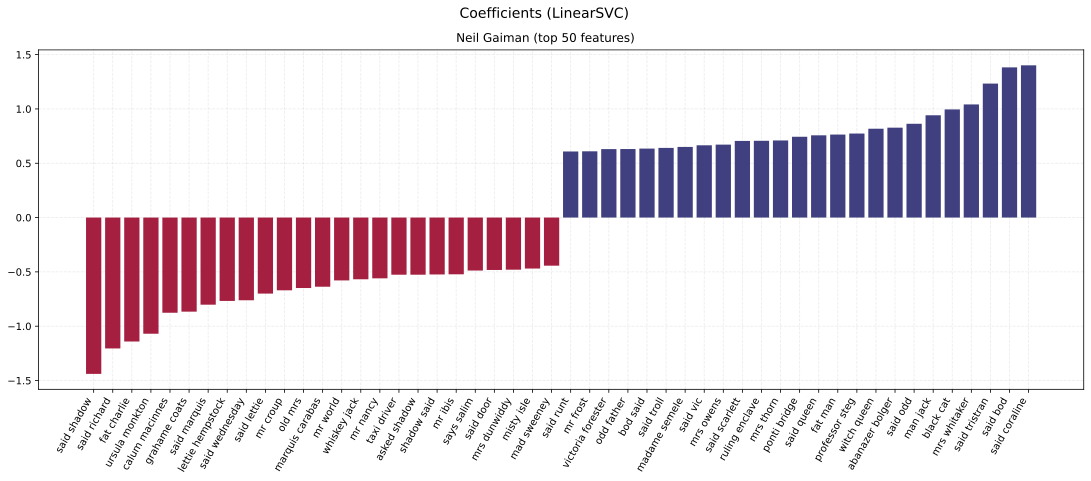

========================================== Philip Pullman ==========================================

X_train: (1280,)	 X_test: (320,)
y_train: (1280,)	 y_test: (320,)

Fitting 10 folds for each of 4 candidates, totalling 40 fits
Best score: 0.909

Default params were overriden by:
{'steps': [('tfidfvectorizer', TfidfVectorizer(lowercase=False, max_df=0.5, max_features=5000,
                ngram_range=(2, 2), stop_words='english')), ('linearsvc', LinearSVC(class_weight='balanced'))], 'tfidfvectorizer': TfidfVectorizer(lowercase=False, max_df=0.5, max_features=5000,
                ngram_range=(2, 2), stop_words='english'), 'linearsvc': LinearSVC(class_weight='balanced'), 'tfidfvectorizer__lowercase': False, 'tfidfvectorizer__max_df': 0.5, 'tfidfvectorizer__ngram_range': (2, 2), 'linearsvc__class_weight': 'balanced'}



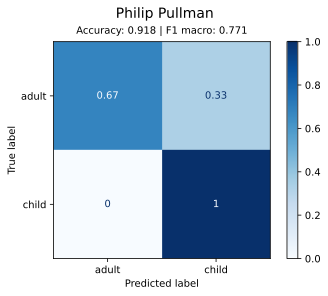

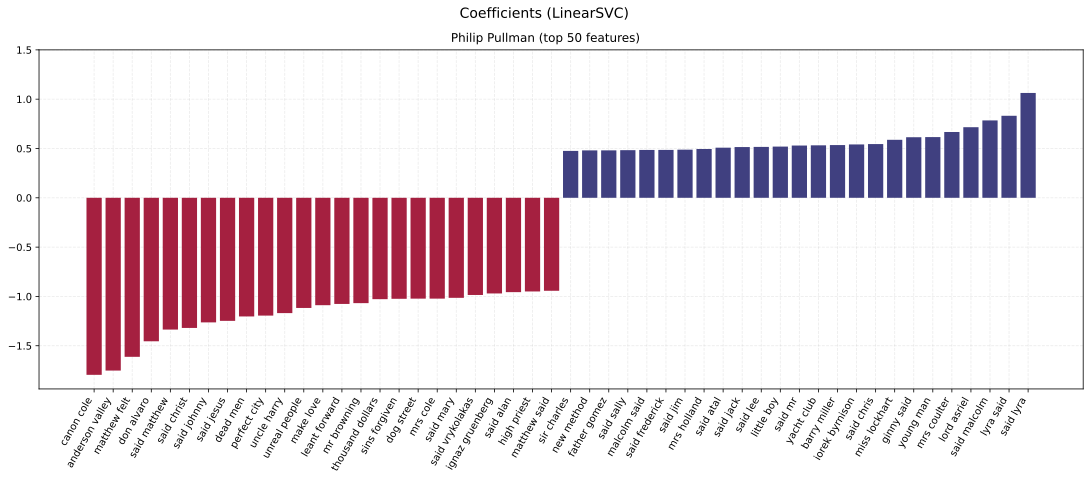

=========================================== J.K. Rowling ===========================================

X_train: (1804,)	 X_test: (451,)
y_train: (1804,)	 y_test: (451,)

Fitting 10 folds for each of 4 candidates, totalling 40 fits
Best score: 0.999

Default params were overriden by:
{'steps': [('tfidfvectorizer', TfidfVectorizer(lowercase=False, max_df=0.5, max_features=5000,
                ngram_range=(2, 2), stop_words='english')), ('linearsvc', LinearSVC(class_weight='balanced'))], 'tfidfvectorizer': TfidfVectorizer(lowercase=False, max_df=0.5, max_features=5000,
                ngram_range=(2, 2), stop_words='english'), 'linearsvc': LinearSVC(class_weight='balanced'), 'tfidfvectorizer__lowercase': False, 'tfidfvectorizer__max_df': 0.5, 'tfidfvectorizer__ngram_range': (2, 2), 'linearsvc__class_weight': 'balanced'}



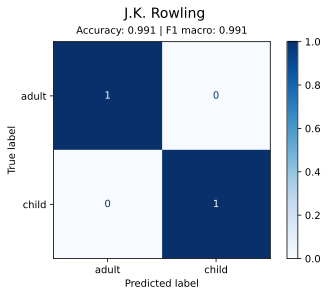

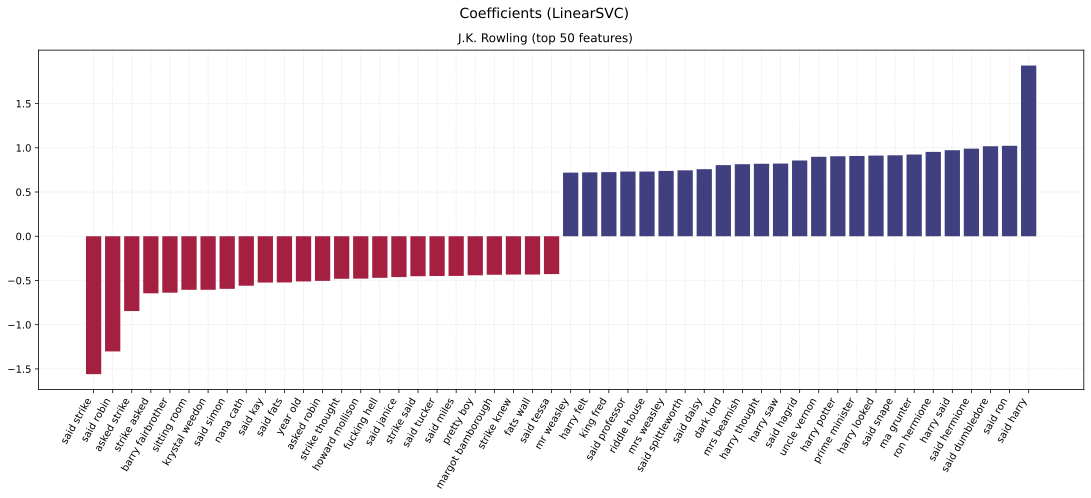

In [15]:
for author in df['author'].unique():

    # Format author name in output
    print(f' {author} '.center(100, "="), end="\n\n")

    # Get subset for `author` and then train/test split
    df_author = df[df['author'] == author]
    author_snake = author.replace(' ', '_').replace('.', '').lower()
    df_author.to_csv(f'data/author_dfs/{author_snake}.csv', index=False, encoding='utf-8')

    X = df_author['text']
    y = df_author['reader_age_group']

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=97, stratify=y)
    print(
        f"X_train: {X_train.shape}\t X_test: {X_test.shape}",
        f"y_train: {y_train.shape}\t y_test: {y_test.shape}",
        sep="\n", end="\n\n"
    )

    # Set up pipeline and grid search
    vect = TfidfVectorizer(max_features=5000, stop_words='english')
    svm  = LinearSVC()
    pipe = make_pipeline(vect, svm)

    param_grid = {
        'linearsvc__class_weight': ['balanced', None],
        'tfidfvectorizer__ngram_range': [(2, 2), (3, 3)],
        'tfidfvectorizer__max_df': [0.5],  # try to avoid overfitting due to characters' names
        'tfidfvectorizer__lowercase': [False]  # already lowercased
    }

    gs = GridSearchCV(
        pipe, 
        param_grid, 
        cv=10, 
        scoring=('accuracy', 'f1_macro'), 
        n_jobs=-1,
        refit='f1_macro',
        verbose=5
    )

    gs.fit(X_train, y_train)

    print(f"Best score: {gs.best_score_:.3f}", end="\n\n")
    pipe_params = pipe.get_params()
    best_params = gs.best_estimator_.get_params()
    print(
        "Default params were overriden by:",
        dict_difference_values(pipe_params, best_params), 
        sep="\n", end="\n\n"
    )

    y_pred = gs.predict(X_test)

    # Plot confusion matrix
    palette = sns.color_palette('gist_stern_r', as_cmap=True)
    classes = [label for label in encoded_labels]
    title = f"{author}".title()

    disp = ConfusionMatrixDisplay.from_estimator(
        gs,
        X_test,
        y_test,
        display_labels=classes,
        cmap=plt.cm.Blues,
        normalize='true'
    )

    plt.suptitle(title, y=1, fontsize=14)

    # Subtitle
    scorers = []
    for scoring, _ in gs.scorer_.items():
        score = gs.cv_results_[f'mean_test_{scoring}'].mean()
        scoring = scoring.replace('_', ' ').capitalize()
        scorers.append(f'{scoring}: {score:.3f}')

    subtitle = " | ".join(scorers)

    disp.ax_.set_title(subtitle, fontsize=10, pad=8)
    disp.ax_.tick_params(axis='x');

    # Plot coefficients
    clf = gs.best_estimator_.named_steps['linearsvc']
    features_names = gs.best_estimator_.named_steps['tfidfvectorizer'].get_feature_names_out()
    plot_coefficients(clf, features_names, who=author, n_features=25)